In [17]:
import warnings
warnings.filterwarnings('ignore')

import math 
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.integrate as integrate
import scipy.stats as stats

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, an Oil ETF, and Tech ETF 

In [18]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 10

Create the subset of assets.

In [19]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_subset = pd.DataFrame()

for M in assetlist: 
    m6_subset[M] = m6[m6['symbol'] == M]['price'].values

1st-order differencing of the rolling average expectation for each asset. 

In [20]:
m6_subset = m6_subset.apply(np.log).rolling(10).mean().diff().dropna()
print(m6_subset)

          IEF       GSG       IXN
10  -0.001878  0.004799 -0.004710
11  -0.002042  0.002259 -0.002013
12  -0.002037  0.001592 -0.002763
13  -0.001077  0.001889 -0.002938
14   0.000018  0.000861 -0.004356
..        ...       ...       ...
194  0.000290  0.005585 -0.001463
195 -0.000286  0.003399 -0.002283
196 -0.000453 -0.001500 -0.002852
197  0.001061 -0.000679  0.006195
198  0.001369  0.001982  0.004565

[189 rows x 3 columns]


Instantiate a non-parametric clustering model using the dirichlet process. 

In [21]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process').fit(m6_subset)

In [22]:
states = dpgmm_model.predict(m6_subset)

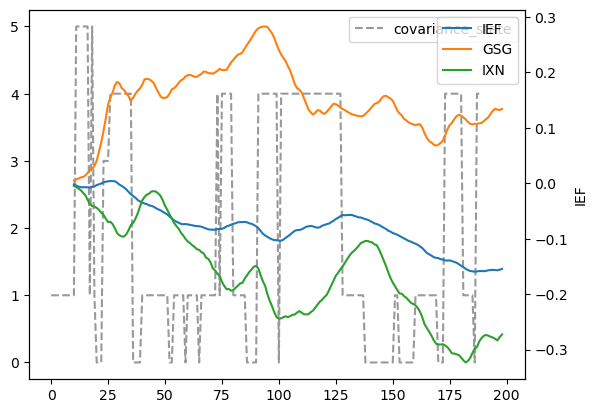

In [23]:
fig,ax = plt.subplots()
axx = ax.twinx()

sns.lineplot(data=states, ax=ax, linestyle='--', color='black', alpha=0.4, label='covariance_state')
sns.lineplot(data=m6_subset['IEF'].cumsum(), ax=axx, label='IEF')
sns.lineplot(data=m6_subset['GSG'].cumsum(), ax=axx, label='GSG')
sns.lineplot(data=m6_subset['IXN'].cumsum(), ax=axx, label='IXN')

plt.legend()
plt.show()

In [24]:
state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

print(dpgmm_model.means_)
print(state_counts)

[[-0.00178788 -0.00286307 -0.00516584]
 [-0.00105968  0.00300968 -0.00370359]
 [-0.00082117  0.00071677 -0.00144706]
 [-0.00290337 -0.00405475  0.00419972]
 [ 0.00016529 -0.00110323  0.00445226]
 [ 0.00063738  0.01395951 -0.00406447]
 [-0.00081713  0.00071023 -0.00144269]
 [-0.00081713  0.00071023 -0.00144269]
 [-0.00081713  0.00071023 -0.00144269]
 [-0.00081713  0.00071023 -0.00144269]]
[41. 76.  0.  3. 62.  7.  0.  0.  0.  0.]
